In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob, os
from rayleighsommerfeld02 import rayleighsommerfeld
from numpy import diff
import pandas as pd
from findpeaks import findpeaks
import pprint

In [1]:
%gui qt5
from PyQt5.Qt import QApplication
import pyqtgraph as pg

app = QApplication.instance() or QApplication([])

### final saved trajectories (n particles for T total time steps) will be a dictionary like this:

### {0: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)], 
### 1: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)], 
### ... , 
### T-1: [(x_1, y_1, z_1), (x_2,y_2,z_2),... (x_n,y_n,z_n)]}

In [3]:
save_data = {}

### get foreground images of video

In [10]:
filelist = glob.glob("./060922/*.avi")
print(filelist[16])
vidcap = cv2.VideoCapture(filelist[16])
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        t = str(count).zfill(4)
        cv2.imwrite(filelist[16][:-4] + "/fg_image_"+t+".png", image)
    return hasFrames
sec = 0
frameRate = 1/30
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

./060922/6-mer_500.avi


### pull up the first image from this experiment

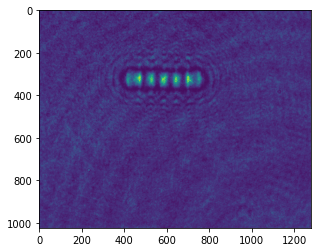

In [13]:
filelist = glob.glob("./060922/*.avi")
fg = plt.imread(filelist[16][:-4] + '/fg_image_0001.png')
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2GRAY)
plt.imshow(fg)

### crop feature to a 512x512 image

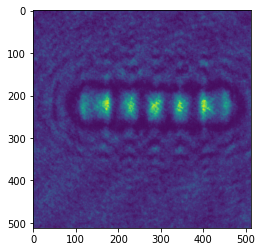

In [14]:
xmin = 300
ymin = 100
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]
plt.imshow(fg_cropped)

### run rayleigh-sommerfeld algorithm 

In [59]:
mpp = 0.048
z = np.linspace(-20, 0, 200) / mpp
b = fg_cropped
rs = rayleighsommerfeld(b, z, magnification=mpp, nozphase=True)
bz = np.abs(rs).astype(float)
phi = np.angle(rs - 1.)

In [16]:
widget = pg.ImageView()
widget.setImage(bz.T)
widget.show()

### pull up image at focus to get $x_1^{(1)}, y_1^{(1)}, x_1^{(2)}, y_1^{(2)},$ etc (chosen manually)

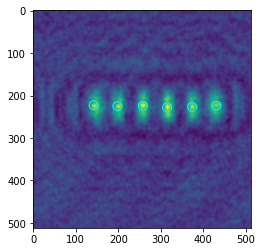

In [60]:
z_guess = 57 # in units of pixels

fig, ax = plt.subplots()
ax.imshow(bz[:,:,z_guess])

zlist = []
xlist = [142, 198, 258, 315, 374, 431]
ylist = [223, 225, 224, 228, 227, 224]

for i in range(len(xlist)):
    ax.scatter(xlist[i],ylist[i],s=80, facecolors='none', edgecolors='cyan')
plt.show()

### use a peakfinder algorithm that we may use later to automatically find monomer centers -- check viability

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [5].
[findpeaks] >Detect peaks using topology method with limit at 50.0.
[findpeaks] >Detect peaks using topology method with limit at 50.0.
[findpeaks] >Fin.


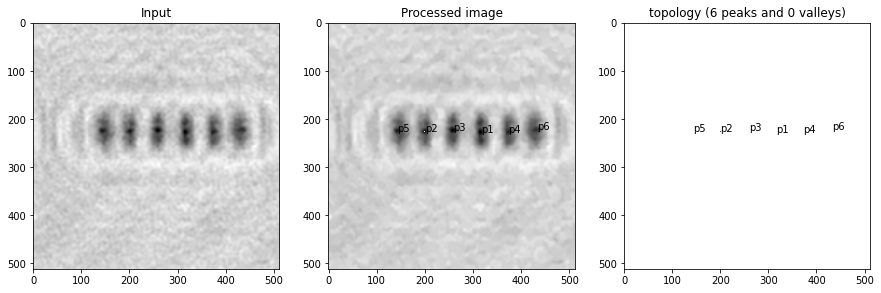

0    316
1    200
2    259
3    373
4    143
5    433
Name: x, dtype: object 0    227
1    226
2    223
3    228
4    225
5    222
Name: y, dtype: object


In [61]:
# Initialize
fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=5, togray=True, limit = 50.)
# Fit
results = fp.fit(bz[:,:,z_guess])
fp.plot()
print(results['persistence'].x, results['persistence'].y)

### just a thought: we know the distance r between monomers, and can search for neighbors by tracing a half circle of known radius

In [19]:
def get_int(A, xc, yc, r): #given some center (xc,yc), what are the intensity values obtained some radius away in an array A?
    n = 100
    max_so_far = 0.
    theta_list = np.linspace(-np.pi,np.pi,n)
    for theta in theta_list:
        x = xc+r*np.cos(theta)
        y = yc+r*np.sin(theta)
        if A[int(y), int(x)] > max_so_far:
            max_so_far = A[int(y), int(x)]
            xmax = x
            ymax = y
    print([x,y])
    return [x,y]
    
get_int(b, xlist[4], ylist[4], 60)

[314.0, 227.0]


[314.0, 227.0]

### get $z_p$ predictions for first frame

-318.2579564489112


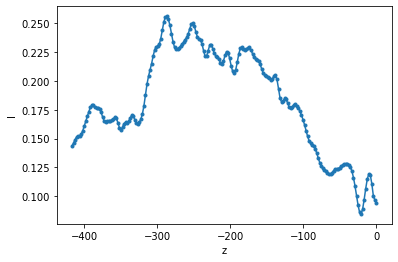

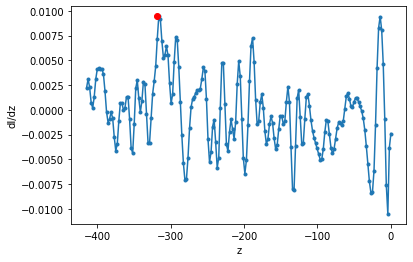

In [31]:
#particle n
index = 5
intensity_list = bz[ylist[index], xlist[index], :]
fig, ax = plt.subplots()
ax.plot(z, intensity_list, '.-')
ax.set_xlabel('z')
ax.set_ylabel('I')

dx = 1.
y = intensity_list
dy = diff(y)/dx

fig, ax = plt.subplots()
ax.plot(z[1:], dy, '.-')

best_so_far = 0
for count, ele in enumerate(dy):
    if ele > best_so_far and count<len(dy)-20:
        best_so_far = ele
        max_count = count
ax.plot(z[max_count], best_so_far, 'ro')
ax.set_xlabel('z')
ax.set_ylabel('dI/dz')

z1 = best_so_far
print(z[max_count])

In [32]:
zlist.append(z[max_count]*-0.048)
print(zlist)

[14.773869346733669, 15.175879396984925, 14.874371859296481, 14.974874371859299, 14.773869346733669, 15.27638190954774]


### Plot the particles xz cross-section (let's see what the chain looks like from the side!)

Text(0, 0.5, 'z (um)')

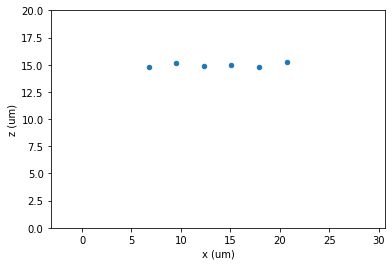

In [33]:
#change to microns
xlist = [x*0.048 for x in xlist]
ylist = [y*0.048 for y in ylist]

fig, ax = plt.subplots()
ax.scatter(xlist, zlist, s=20)
ax.set_ylim(0, 20)
ax.set_xlim(min(xlist)-10, max(xlist)+10)
ax.set_xlabel('x (um)')
ax.set_ylabel('z (um)')

### save to dictionary

In [34]:
framenum = 0
frame = []
for i in range(len(xlist)):
    x = xlist[i]
    y = ylist[i]
    z = zlist[i]
    frame.append((x,y,z))
save_data[framenum] = frame
print(save_data)

{0: [(6.816, 10.704, 14.773869346733669), (9.504, 10.8, 15.175879396984925), (12.384, 10.752, 14.874371859296481), (15.120000000000001, 10.944, 14.974874371859299), (17.952, 10.896, 14.773869346733669), (20.688, 10.752, 15.27638190954774)]}


### <font color='green'>Helper Function:</font> find closest coordinates for query  (xq, yq)

In [35]:
def get_closest_coords(xq, yq, xlist, ylist):
    dist = [(xlist[i]-xq)**2 + (ylist[i]-yq)**2 for i in range(len(xlist))]
    min_index = dist.index(min(dist))
    return min_index

### now that we have initial guesses, let's try to automate the process (the whole point of all of this)

In [ ]:
framenum = 3

n = 6
current_x_list = []
current_y_list = []
current_z_list = []

#get image and crop
t = str(framenum).zfill(4)
fg = plt.imread(filelist[16][:-4] + '/fg_image_{}.png'.format(t))
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2GRAY)
fg_cropped = fg[ymin:ymin+512, xmin: xmin+512]

for i in range(n):
    
    #get initial x,y guesses in units of pixels on a 512x512 grid. convert z later
    x0 = save_data[framenum-1][i][0]/0.048
    y0 = save_data[framenum-1][i][1]/0.048
    z0 = save_data[framenum-1][i][2]
    
    #we have a guess for z0. Run rayleigh sommerfeld for a smaller range of z, centered around this guess
    nz = 20
    z = np.linspace(int(z0/0.048) - nz, int(z0/0.048) + nz, 2*nz+1)
    #only rayleigh sommerfeld around our guess value for z to save computation time
    rs = rayleighsommerfeld(fg_cropped, z, magnification=mpp, nozphase=True)
    bz = np.abs(rs).astype(float)
    
    #take the frame for our guess and get precise values for x,y by using peakfinder algorithm from above
    b = bz[:,:,int(nz/2)]
    #peakfinding:
    thresh = 30
    win = 15 
    fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=win, togray=True, limit = thresh)
    results = fp.fit(b)
    k = len(results['persistence'].x)
    while k<n+4:
        thresh -= 2
        fp = findpeaks(method='topology', scale=True, denoise='fastnl', window=win, togray=True, limit = thresh)
        results = fp.fit(b)
        k = len(results['persistence'].x)
    x_fit = results['persistence'].x
    y_fit = results['persistence'].y

    index = get_closest_coords(x0, y0, x_fit, y_fit)
    x = x_fit[index]
    y = y_fit[index]
    print('x guess:', x0, 'x fit:', x, 'y_guess:', y0, 'y_fit:', y)
    
    #now we have exact x and y values. Look at intensity list at that location across different z's
    intensity_list = bz[y,x,:]
    dx = 1
    dy = diff(intensity_list)/dx
    #choose z value for which gradient of intensity dI/dz is maximized, ignoring points close to 0.
    best_so_far = 0
    for count, ele in enumerate(dy):
        if ele > best_so_far and count<len(dy)-20:
            best_so_far = ele
            max_count = count
    zf = z[max_count]
    
    current_x_list.append(x*0.048)
    current_y_list.append(y*0.048)
    current_z_list.append(zf*0.048)

    
#print all results
print(current_x_list, current_y_list, current_z_list)

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [15].
[findpeaks] >Detect peaks using topology method with limit at 30.
[findpeaks] >Detect peaks using topology method with limit at 30.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [15].
[findpeaks] >Detect peaks using topology method with limit at 28.
[findpeaks] >Detect peaks using topology method with limit at 28.
[findpeaks] >Fin.
[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] 

Text(0, 0.5, 'z (um)')

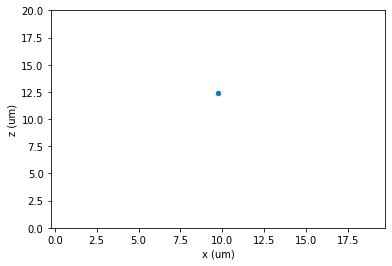

In [75]:
fig, ax = plt.subplots()
ax.scatter(current_x_list, current_z_list, s=20)
ax.set_ylim(0, 20)
ax.set_xlim(min(current_x_list)-10, max(current_x_list)+10)
ax.set_xlabel('x (um)')
ax.set_ylabel('z (um)')

### if it all looks good, save 

In [80]:
frame = []
#for i in range(len(current_x_list)):
#    x = current_x_list[i]
#    y = current_y_list[i]
#    z = current_z_list[i]
#    frame.append((x,y,z))
#save_data[framenum] = frame
pprint.pprint(save_data)
np.save('trajectories.npy', save_data)

{0: [(6.816, 10.704, 14.773869346733669),
     (9.504, 10.8, 15.175879396984925),
     (12.384, 10.752, 14.874371859296481),
     (15.120000000000001, 10.944, 14.974874371859299),
     (17.952, 10.896, 14.773869346733669),
     (20.688, 10.752, 15.27638190954774)],
 1: [(6.816, 10.704, 13.776),
     (9.6, 10.848, 14.208),
     (12.384, 10.752, 13.872),
     (15.120000000000001, 10.944, 13.968),
     (17.904, 10.944, 13.776),
     (20.736, 10.8, 14.4)],
 2: [(7.008, 10.8, 13.104000000000001),
     (9.552, 10.848, 13.632),
     (12.048, 10.704, 13.392),
     (15.36, 10.944, 13.056000000000001),
     (17.904, 10.944, 12.912),
     (20.64, 10.704, 13.44)]}
